# StyleGAN

In [6]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import os
from glob import glob



os.environ['CUDA_VISIBLE_DEVICES']='1, 2'

class Config:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def __str__(self):
        params = ", ".join(f"{k}={v}" for k, v in self.__dict__.items())
        return f"Config({params})"

    def __repr__(self):
        return self.__str__()

    def add_param(self, key, value):
        setattr(self, key, value)

In [7]:
config = Config(
    n_gpu=2,
    device=torch.device('cuda:0'),
    image_size=512,
    learning_rate={128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003},
    batch_size_1gpu={4: 128, 8: 128, 16: 64, 32: 32, 64: 16, 128: 16},
    mini_batch_size_1=8,
    batch_size={4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16},
    mini_batch_size=8,
    batch_size_4gpus={4: 512, 8: 256, 16: 128, 32: 64, 64: 32},
    mini_batch_size_4=16,
    batch_size_8gpus={4: 512, 8: 256, 16: 128, 32: 64},
    mini_batch_size_8=32,
    n_fc=8,
    dim_latent=512,
    dim_input=4,
    n_sample=120000,
    DGR=1,
    n_show_loss=40,
    step=1,
    max_step=8,
    style_mixing=[], 
    image_folder_path='./dataset/',
    save_folder_path='./results/',
    low_steps=[0, 1, 2],
    mid_steps=[3, 4, 5],
    hig_steps=[6, 7, 8],
    startpoint=0,
    used_sample=0,
    alpha=0,
    is_train=True,
    is_continue=True,
    d_losses=[float('inf')],
    g_losses=[float('inf')]
)

inputs, outputs = [], []

# Data

In [8]:
dataset_root = 'img_align_celeba/img_align_celeba/*'
dataset_paths = glob(os.path.join(dataset_root))
dataset_paths=dataset_paths[:100]

In [9]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

class CustomDataset(Dataset):
    def __init__(self, dataset, transform):
        super(CustomDataset, self).__init__()
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = Image.open(self.dataset[idx]).convert('RGB')
        return self.transform(img)
        
dataset = CustomDataset(dataset_paths, preprocess)

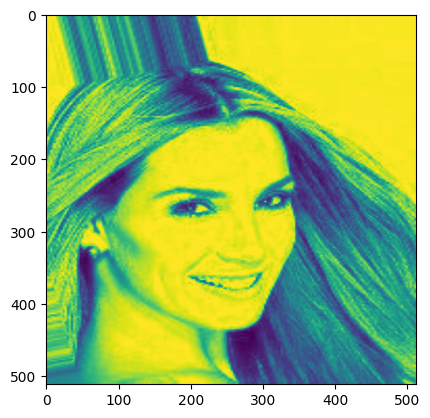

In [10]:
import matplotlib.pyplot as plt

img=next(iter(dataset))
plt.imshow(img[0].numpy())
plt.show()

In [11]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import math

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline

In [12]:
class ScaleW:
    def __init__(self, name):
        self.name = name

    def scale(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()
        return weight * math.sqrt(2 / fan_in)

    @staticmethod
    def apply(module, name):
        '''
        Apply runtime scaling to specific module
        '''
        hook = ScaleW(name)
        weight = getattr(module, name)
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        del module._parameters[name]
        module.register_forward_pre_hook(hook)
    
    def __call__(self, module, whatever):
        weight = self.scale(module)
        setattr(module, self.name, weight)


def scaler(module, name="weight"):
    ScaleW.apply(module, name)
    return module


class ScaleLinear(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(ScaleLinear, self).__init__()     
        linear = nn.Linear(dim_in, dim_out)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        self.linear = scaler(linear)

    def forward(self, x):
        return self.linear(x)

class ScaleConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ScaleConv2d, self).__init__()
        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()

        self.conv = scaler(conv)

    def forward(self, x):
        return self.conv(x)

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)


class AffineTransform(nn.Module):
    """
    [A] - Affine transform
    """
    def __init__(self, w_dim, channels):
        super(AffineTransform, self).__init__()
        self.fc = ScaleLinear(w_dim, channels * 2)
        self.fc.linear.bias.data[:channels] = 1
        self.fc.linear.bias.data[channels:] = 0

    def forward(self, w):
        gamma, beta = self.fc(w).chunk(2, dim=1)
        return gamma.unsqueeze(2).unsqueeze(3), beta.unsqueeze(2).unsqueeze(3)

class AdaIN(nn.Module):
    def __init__(self, in_channels):
        super(AdaIN, self).__init__()
        self.norm = nn.InstanceNorm2d(in_channels)

    def forward(self, img, param):
        gamma, beta = param
        norm = self.norm(img)
        return norm * gamma + beta

class Scale_B(nn.Module):
    """
    used to scale the noise
    """
    def __init__(self, in_channels):
        super(Scale_B, self).__init__()
        self.weight = nn.Parameter(torch.zeros((1, in_channels, 1, 1)))

    def forward(self, noise):
        return noise * self.weight        


class ConvBlock(nn.Module):
    '''
    Used to construct progressive discriminator
    '''
    def __init__(self, in_channels, out_channels, 
                 kernel_size1, padding1, 
                 kernel_size2 = None, padding2 = None):
        super(ConvBlock, self).__init__()

        kernel_size2 = kernel_size1 if kernel_size2 is None else kernel_size2
        padding2 = padding1 if padding2 is None else padding2

        self.conv = nn.Sequential(
            ScaleConv2d(in_channels, out_channels, kernel_size1, padding=padding1),
            nn.LeakyReLU(0.2),
            ScaleConv2d(out_channels, out_channels, kernel_size2, padding=padding2),
            nn.LeakyReLU(0.2)
        )

    def forward(self, img):
        return self.conv(img)

class Early_StyleConv_Block(nn.Module):
    """
    The block of generator that get the constant value as input
    """
    def __init__(self, in_channels, dim_latent, dim_input):
        super(Early_StyleConv_Block, self).__init__()
        self.constant = nn.Parameter(torch.randn(1, in_channels, dim_input, dim_input))

        self.style1 = AffineTransform(dim_latent, in_channels)
        self.style2 = AffineTransform(dim_latent, in_channels)

        self.noise1 = scaler(Scale_B(in_channels))
        self.noise2 = scaler(Scale_B(in_channels))

        self.adain = AdaIN(in_channels)
        self.lrelu = nn.LeakyReLU(0.2)

        self.conv = ScaleConv2d(in_channels, in_channels, 3, padding=1)

    def forward(self, latent_w, noise):
        result = self.constant.repeat(noise.shape[0], 1, 1, 1)

        result = result + self.noise1(noise)
        result = self.adain(result, self.style1(latent_w))
        result = self.lrelu(result)
        
        result = self.conv(result)

        result = result + self.noise2(noise)
        result = self.adain(result, self.style2(latent_w))
        result = self.lrelu(result)

        return result
        
        
class StyleConv_Block(nn.Module):
    """
    The block of generator that get the constant value as input
    """
    def __init__(self, in_channels, out_channels, dim_latent):
        super(StyleConv_Block, self).__init__()
        self.style1 = AffineTransform(dim_latent, out_channels)
        self.style2 = AffineTransform(dim_latent, out_channels)

        self.noise1 = scaler(Scale_B(out_channels))
        self.noise2 = scaler(Scale_B(out_channels))

        self.adain = AdaIN(out_channels)
        self.lrelu = nn.LeakyReLU(0.2)

        self.conv1 = ScaleConv2d(in_channels, in_channels, 3, padding=1)
        self.conv2 = ScaleConv2d(out_channels, out_channels, 3, padding=1)

    def forward(self, previous_result, latent_w, noise):
        result = self.conv1(previous_result)
        
        result = result + self.noise1(noise)
        result = self.adain(result, self.style1(latent_w))
        result = self.lrelu(result)
        
        result = self.conv2(result)

        result = result + self.noise2(noise)
        result = self.adain(result, self.style2(latent_w))
        result = self.lrelu(result)

        return result    


In [13]:
class MappingNetwork(nn.Module):
    '''
    A mapping consists of multiple fully connected layers.
    Used to map the input to an intermediate latent space W.
    '''
    def __init__(self, dim_latent, num_layers=8):
        super(MappingNetwork, self).__init__()
        layers = [PixelNorm()]
        for _ in range(num_layers):
            layers.append(ScaleLinear(dim_latent, dim_latent))
            layers.append(nn.LeakyReLU(0.2))

        self.mapping = nn.Sequential(*layers)

    def forward(self, x):
        return self.mapping(x)
            

class Generator(nn.Module):
    def __init__(self, num_fc, dim_latent, dim_input):
        super(Generator, self).__init__()
        self.mapping_net = MappingNetwork(dim_latent=dim_latent, num_layers=num_fc)
        self.convs = nn.ModuleList([
            Early_StyleConv_Block(512, dim_latent, dim_input),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 256, dim_latent),
            StyleConv_Block(256, 128, dim_latent),
            StyleConv_Block(128, 64, dim_latent),
            StyleConv_Block(64, 32, dim_latent),
            StyleConv_Block(32, 16, dim_latent)
        ])

        self.to_rgbs = nn.ModuleList([
            ScaleConv2d(512, 3, 1),
            ScaleConv2d(512, 3, 1),
            ScaleConv2d(512, 3, 1),
            ScaleConv2d(512, 3, 1),
            ScaleConv2d(256, 3, 1),
            ScaleConv2d(128, 3, 1),
            ScaleConv2d(64, 3, 1),
            ScaleConv2d(32, 3, 1),
            ScaleConv2d(16, 3, 1)
        ])

    def forward(self, latent_z, step=0, alpha=-1, noise=None, mix_steps=[]):
        if (len(latent_z) != 2 and len(mix_steps) > 0) or type(mix_steps) != []:
            mix_steps = []
        
        latent_w = [self.mapping_net(latent) for latent in latent_z]
        result = 0
        current_latent = 0

        for i, conv in enumerate(self.convs):
            
            if i in mix_steps:
                current_latent = latent_w[1]
            else:
                current_latent = latent_w[0]
                
            if i > 0 and step > 0:
                result_upsample = nn.functional.interpolate(result, scale_factor=2, mode='bilinear',
                                                  align_corners=False)
                result = conv(result_upsample, current_latent, noise[i])
            else:
                result = conv(current_latent, noise[i])
            
            if i == step:
                result = self.to_rgbs[i](result)
                if i > 0 and 0 <= alpha < 1:
                    result_prev = self.to_rgbs[i - 1](result_upsample)
                    result = alpha * result + (1 - alpha) * result_prev                    
                break
        return result



class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.from_rgbs = nn.ModuleList([
            ScaleConv2d(3, 16, 1),
            ScaleConv2d(3, 32, 1),
            ScaleConv2d(3, 64, 1),
            ScaleConv2d(3, 128, 1),
            ScaleConv2d(3, 256, 1),
            ScaleConv2d(3, 512, 1),
            ScaleConv2d(3, 512, 1),
            ScaleConv2d(3, 512, 1),
            ScaleConv2d(3, 512, 1)
       ])
        self.convs  = nn.ModuleList([
            ConvBlock(16, 32, 3, 1),
            ConvBlock(32, 64, 3, 1),
            ConvBlock(64, 128, 3, 1),
            ConvBlock(128, 256, 3, 1),
            ConvBlock(256, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(513, 512, 3, 1, 4, 0)
        ])
        self.fc = ScaleLinear(512, 1)
        
        self.n_layer = 9
    
    def forward(self, image, step = 0, alpha=-1): 
        
        for i in range(step, -1, -1):
            layer_index = self.n_layer - i - 1 
            
            if i == step: 
                result = self.from_rgbs[layer_index](image)
            
            if i == 0:
                res_var = result.var(0, unbiased=False) + 1e-8
                res_std = torch.sqrt(res_var)
                mean_std = res_std.mean().expand(result.size(0), 1, 4, 4)
                result = torch.cat([result, mean_std], 1)
            
            result = self.convs[layer_index](result)
            
            if i > 0:
                result = nn.functional.interpolate(result, scale_factor=0.5, mode='bilinear', align_corners=False)
                
                if i == step and 0 <= alpha < 1:
                    result_next = self.from_rgbs[layer_index + 1](image)
                    result_next = nn.functional.interpolate(result_next, scale_factor=0.5, mode = 'bilinear', align_corners=False)
                    result = alpha * result + (1 - alpha) * result_next
                
        result = result.squeeze(2).squeeze(2)
        result = self.fc(result)
        return result

In [14]:
config

Config(n_gpu=2, device=cuda:0, image_size=512, learning_rate={128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}, batch_size_1gpu={4: 128, 8: 128, 16: 64, 32: 32, 64: 16, 128: 16}, mini_batch_size_1=8, batch_size={4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16}, mini_batch_size=8, batch_size_4gpus={4: 512, 8: 256, 16: 128, 32: 64, 64: 32}, mini_batch_size_4=16, batch_size_8gpus={4: 512, 8: 256, 16: 128, 32: 64}, mini_batch_size_8=32, n_fc=8, dim_latent=512, dim_input=4, n_sample=120000, DGR=1, n_show_loss=40, step=1, max_step=8, style_mixing=[], image_folder_path=./dataset/, save_folder_path=./results/, low_steps=[0, 1, 2], mid_steps=[3, 4, 5], hig_steps=[6, 7, 8], startpoint=0, used_sample=0, alpha=0, is_train=True, is_continue=True, d_losses=[inf], g_losses=[inf])

In [15]:
n_gpu             = 2
device            = torch.device('cuda:0')

learning_rate     = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}
batch_size_1gpu   = {4: 128, 8: 128, 16: 64, 32: 32, 64: 16, 128: 16}
mini_batch_size_1 = 8
batch_size        = {4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16}
mini_batch_size   = 8
batch_size_4gpus  = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32}
mini_batch_size_4 = 16
batch_size_8gpus  = {4: 512, 8: 256, 16: 128, 32: 64}
mini_batch_size_8 = 32
n_fc              = 8
dim_latent        = 512
dim_input         = 4
n_sample          = 120000
DGR               = 1
n_show_loss       = 40
step              = 1 
max_step          = 8 
style_mixing      = []
save_folder_path  = './results/'

low_steps         = [0, 1, 2]
mid_steps         = [3, 4, 5]
hig_steps         = [6, 7, 8]

startpoint        = 0
used_sample       = 0
alpha             = 0
is_train          = True

is_continue       = True
d_losses          = [float('inf')]
g_losses          = [float('inf')]
inputs, outputs = [], []


def set_grad_flag(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

def reset_LR(optimizer, lr):
    for pam_group in optimizer.param_groups:
        mul = pam_group.get('mul', 1)
        pam_group['lr'] = lr * mul

# adapt sample size
def gain_sample(dataset, batch_size, image_size=4):
    transform = transforms.Compose([
            transforms.Resize(image_size),        
            transforms.CenterCrop(image_size),    
            transforms.RandomHorizontalFlip(),    
            transforms.ToTensor(),            
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset.transform = transform
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=8)
    return loader


def imshow(tensor, i):
    grid = tensor[0]
    grid.clamp_(-1, 1).add_(1).div_(2)
    
    ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    plt.imshow(img)
    plt.show()

# Train

In [18]:
def train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint=0, used_sample=0, d_losses = [], g_losses = [], alpha=0):
    resolution  = 4 * 2 ** step

    origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
    data_loader = iter(origin_loader)

    reset_LR(g_optim, learning_rate.get(resolution, 0.001))
    reset_LR(d_optim, learning_rate.get(resolution, 0.001))

    progress_bar = tqdm(range(startpoint + 1, n_sample))
    
    for i in progress_bar:
        alpha = min(1, alpha + batch_size.get(resolution, mini_batch_size) / (n_sample * 2))

        if used_sample > n_sample * 2 and step < max_step:
            step += 1

            alpha = 0
            used_sample = 0

            resolution = 4 * 2 ** step

            # Avoid possble memory leak
            del origin_loader
            del data_loader
            torch.cuda.empty_cache()

            # Change batch size
            origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
            data_loader = iter(origin_loader)

            reset_LR(g_optim, learning_rate.get(resolution, 0.001))
            reset_LR(d_optim, learning_rate.get(resolution, 0.001))


        try:
            real_image = next(data_loader)
        except (OSError, StopIteration):
            data_loader = iter(origin_loader)
            real_image = next(data_loader)
        
        used_sample += real_image.shape[0]
        real_image = real_image.to(device)
        
        discriminator.zero_grad()
        set_grad_flag(discriminator, True)
        set_grad_flag(generator, False)
        
        real_image.requires_grad = True
        if n_gpu > 1:
            real_predict = nn.parallel.data_parallel(discriminator, (real_image, step, alpha), range(n_gpu))
        else:
            real_predict = discriminator(real_image, step, alpha)
        real_predict = nn.functional.softplus(-real_predict).mean()
        real_predict.backward(retain_graph=True)

        grad_real = torch.autograd.grad(outputs=real_predict.sum(), inputs=real_image, create_graph=True)[0]
        grad_penalty_real = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty_real = 10 / 2 * grad_penalty_real
        grad_penalty_real.backward()
        
        latent_w1 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]
        latent_w2 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]

        noise_1 = []
        noise_2 = []
        for m in range(step + 1):
            size = 4 * 2 ** m 
            noise_1.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
            noise_2.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
        
        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w1, step, alpha, noise_1), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else:
            fake_image = generator(latent_w1, step, alpha, noise_1)
            fake_predict = discriminator(fake_image, step, alpha)

        fake_predict = nn.functional.softplus(fake_predict).mean()
        fake_predict.backward()
        
        if i % n_show_loss == 0:
            d_losses.append((real_predict + fake_predict).item())
        
        d_optim.step()
        
        del grad_penalty_real, grad_real, fake_predict, real_predict, fake_image, real_image, latent_w1
                   
        if i % DGR != 0: continue
        generator.zero_grad()
        set_grad_flag(discriminator, False)
        set_grad_flag(generator, True)
        
        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w2, step, alpha, noise_2), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else: 
            fake_image = generator(latent_w2, step, alpha, noise_2)
            fake_predict = discriminator(fake_image, step, alpha)
        fake_predict = nn.functional.softplus(-fake_predict).mean()
        fake_predict.backward()
        g_optim.step()

        if i % n_show_loss == 0:
            g_losses.append(fake_predict.item())
            imshow(fake_image.data.cpu(), i)
            
        del fake_predict, fake_image, latent_w2

        if (i + 1) % 1000 == 0:
            torch.save({
                'generator'    : generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_optim'      : g_optim.state_dict(),
                'd_optim'      : d_optim.state_dict(),
                'parameters'   : (step, i, used_sample, alpha),
                'd_losses'     : d_losses,
                'g_losses'     : g_losses
            }, 'checkpoints/style_gan/trained.pth')
            print(f'Iteration {i} successfully saved.')
            counter = 0
        
        progress_bar.set_description((f'Resolution: {resolution}*{resolution}  D_Loss: {d_losses[-1]:.4f}  G_Loss: {g_losses[-1]:.4f}  Alpha: {alpha:.4f}'))
    return d_losses, g_losses

Loading pre-trained model...


  0%|                                                                                                                                                                            | 0/115000 [00:00<?, ?it/s]

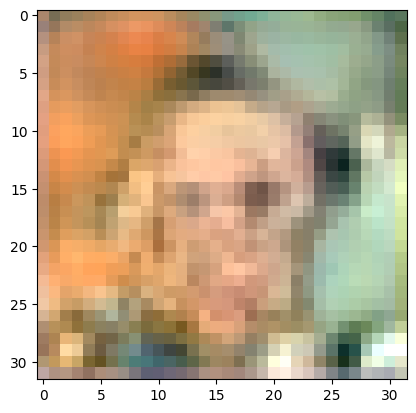

Resolution: 32*32  D_Loss: 0.1092  G_Loss: 4.1811  Alpha: 0.8432:   0%|                                                                                              | 40/115000 [00:17<13:03:51,  2.44it/s]

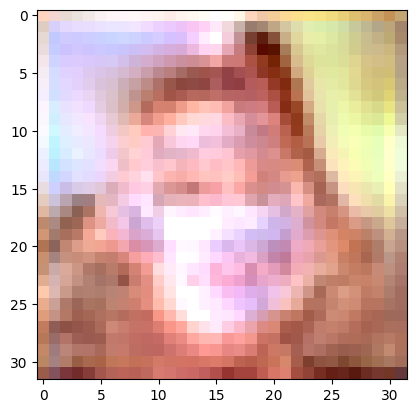

Resolution: 32*32  D_Loss: 0.1430  G_Loss: 4.3540  Alpha: 0.8539:   0%|                                                                                              | 80/115000 [00:34<12:48:49,  2.49it/s]

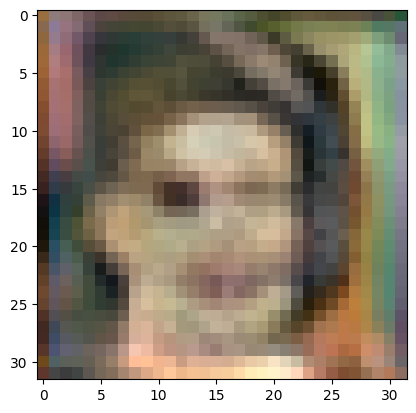

Resolution: 32*32  D_Loss: 0.1458  G_Loss: 7.0097  Alpha: 0.8645:   0%|                                                                                             | 120/115000 [00:52<13:00:09,  2.45it/s]

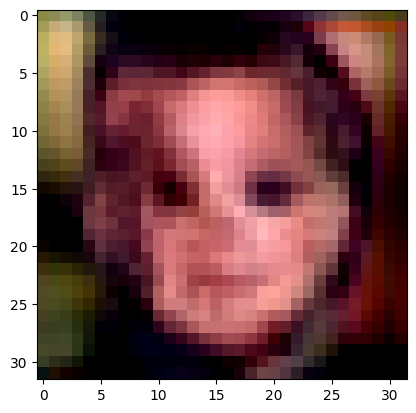

Resolution: 32*32  D_Loss: 0.1335  G_Loss: 6.2305  Alpha: 0.8752:   0%|▏                                                                                            | 160/115000 [01:09<12:51:13,  2.48it/s]

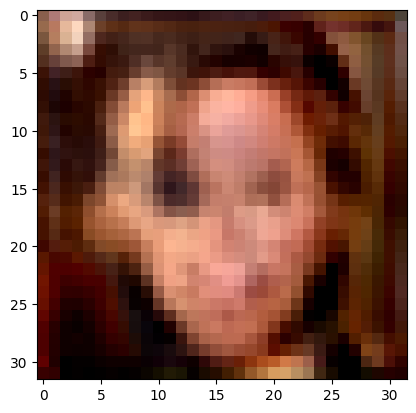

Resolution: 32*32  D_Loss: 0.1715  G_Loss: 3.2723  Alpha: 0.8859:   0%|▏                                                                                            | 200/115000 [01:26<12:59:32,  2.45it/s]

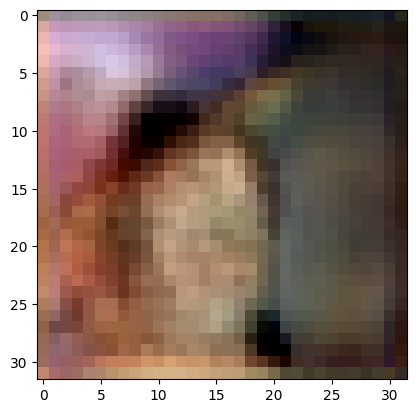

Resolution: 32*32  D_Loss: 0.1996  G_Loss: 6.3300  Alpha: 0.8965:   0%|▏                                                                                            | 240/115000 [01:44<12:52:01,  2.48it/s]

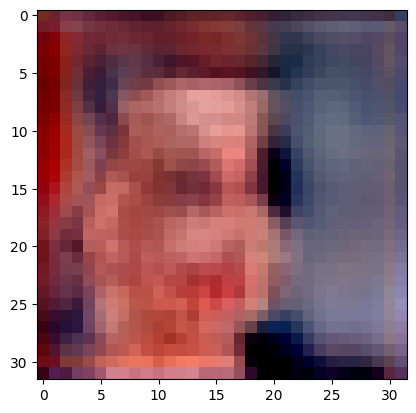

Resolution: 32*32  D_Loss: 0.0156  G_Loss: 8.3422  Alpha: 0.9072:   0%|▏                                                                                            | 280/115000 [02:01<12:57:48,  2.46it/s]

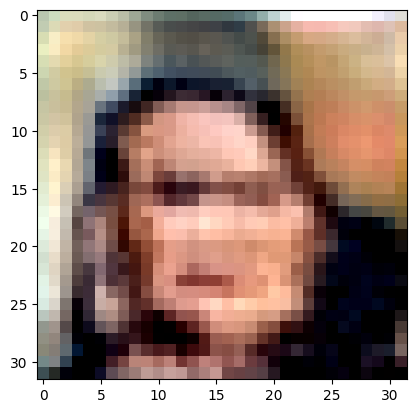

Resolution: 32*32  D_Loss: 0.0270  G_Loss: 5.3706  Alpha: 0.9179:   0%|▎                                                                                            | 320/115000 [02:18<12:52:02,  2.48it/s]

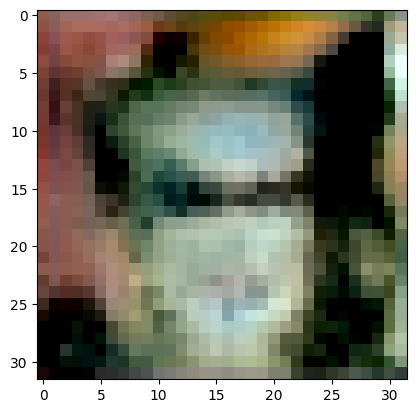

Resolution: 32*32  D_Loss: 0.0820  G_Loss: 5.0474  Alpha: 0.9285:   0%|▎                                                                                            | 360/115000 [02:35<13:05:56,  2.43it/s]

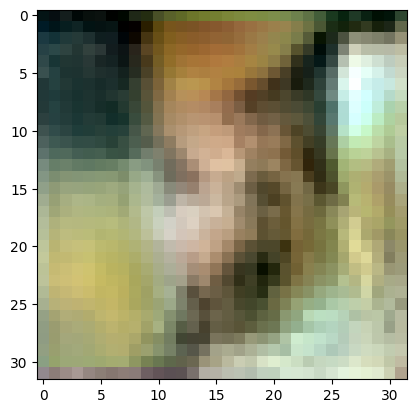

Resolution: 32*32  D_Loss: 0.0157  G_Loss: 7.6745  Alpha: 0.9392:   0%|▎                                                                                            | 400/115000 [02:52<13:06:10,  2.43it/s]

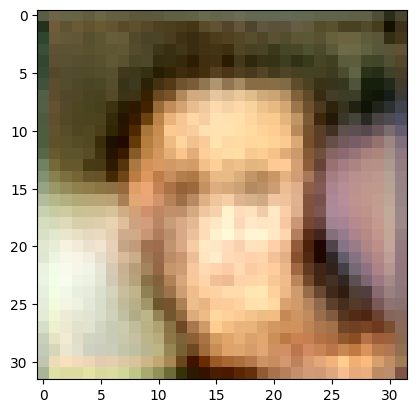

Resolution: 32*32  D_Loss: 0.0713  G_Loss: 3.8326  Alpha: 0.9499:   0%|▎                                                                                            | 440/115000 [03:10<12:54:29,  2.47it/s]

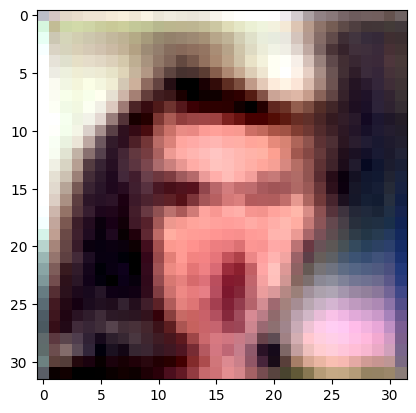

Resolution: 32*32  D_Loss: 0.0157  G_Loss: 6.8203  Alpha: 0.9605:   0%|▍                                                                                            | 480/115000 [03:27<12:59:49,  2.45it/s]

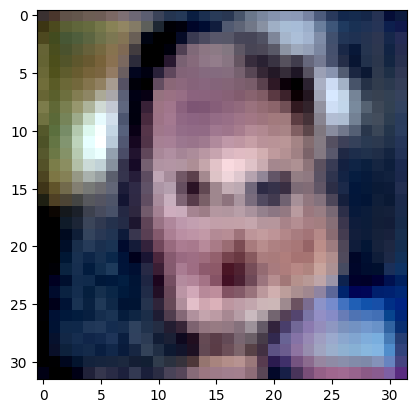

Resolution: 32*32  D_Loss: 0.0151  G_Loss: 6.7028  Alpha: 0.9712:   0%|▍                                                                                            | 520/115000 [03:44<12:52:31,  2.47it/s]

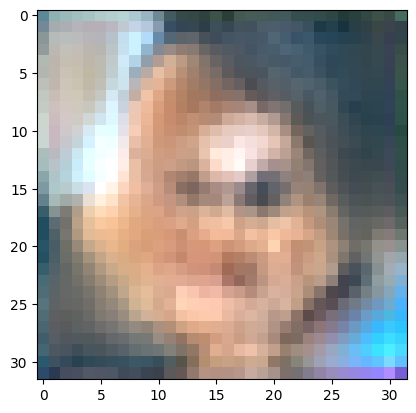

Resolution: 32*32  D_Loss: 20.4719  G_Loss: 0.4439  Alpha: 0.9819:   0%|▍                                                                                           | 560/115000 [04:02<12:53:42,  2.47it/s]

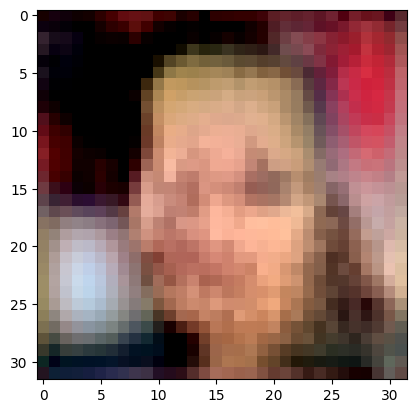

Resolution: 32*32  D_Loss: 0.0275  G_Loss: 5.2574  Alpha: 0.9925:   1%|▍                                                                                            | 600/115000 [04:19<12:53:26,  2.47it/s]

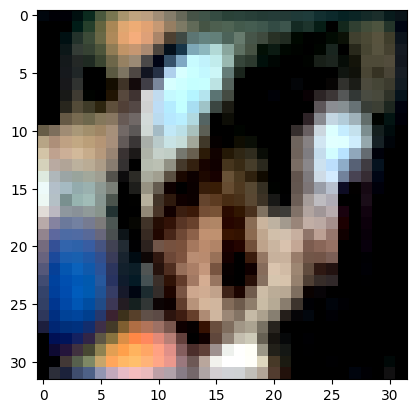

Resolution: 32*32  D_Loss: 0.0210  G_Loss: 5.6680  Alpha: 1.0000:   1%|▌                                                                                            | 640/115000 [04:36<12:10:57,  2.61it/s]

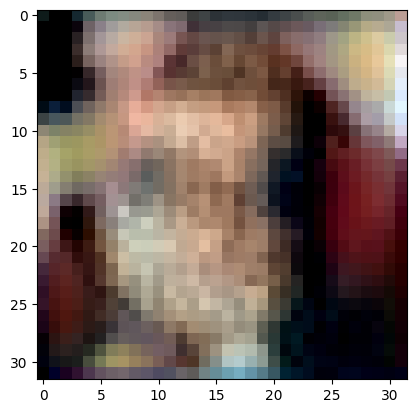

Resolution: 32*32  D_Loss: 0.0816  G_Loss: 3.8143  Alpha: 1.0000:   1%|▌                                                                                            | 680/115000 [04:52<12:09:00,  2.61it/s]

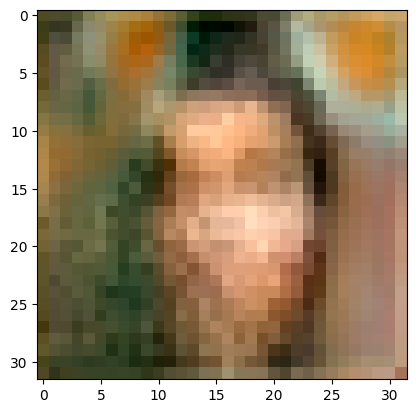

Resolution: 32*32  D_Loss: 0.0170  G_Loss: 5.4764  Alpha: 1.0000:   1%|▌                                                                                            | 720/115000 [05:09<12:12:46,  2.60it/s]

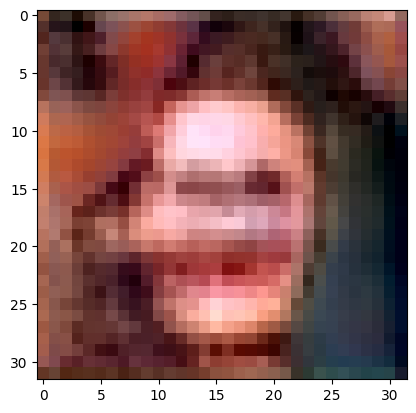

Resolution: 32*32  D_Loss: 0.0116  G_Loss: 8.9994  Alpha: 1.0000:   1%|▌                                                                                            | 760/115000 [05:25<12:07:45,  2.62it/s]

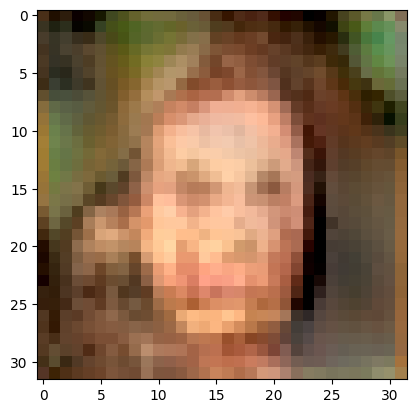

Resolution: 32*32  D_Loss: 0.2407  G_Loss: 3.9976  Alpha: 1.0000:   1%|▋                                                                                            | 800/115000 [05:41<12:11:50,  2.60it/s]

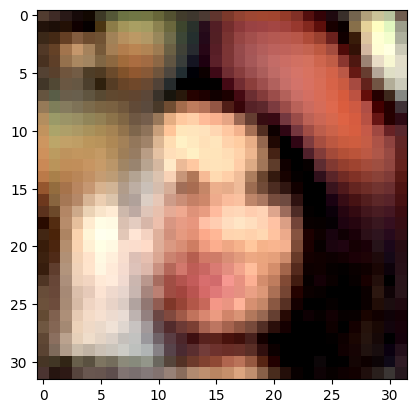

Resolution: 32*32  D_Loss: 0.0571  G_Loss: 6.3113  Alpha: 1.0000:   1%|▋                                                                                            | 803/115000 [05:44<13:35:35,  2.33it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/mnt/tank/scratch/rgurtsiev/miniconda3/envs/my_env/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 96, in _worker
    output = module(*input, **kwargs)
  File "/mnt/tank/scratch/rgurtsiev/miniconda3/envs/my_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/mnt/tank/scratch/rgurtsiev/miniconda3/envs/my_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_3431219/3986964.py", line 76, in forward
    result = conv(result_upsample, current_latent, noise[i])
  File "/mnt/tank/scratch/rgurtsiev/miniconda3/envs/my_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/mnt/tank/scratch/rgurtsiev/miniconda3/envs/my_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_3431219/1889013586.py", line 189, in forward
    result = result + self.noise1(noise)
RuntimeError: The size of tensor a (512) must match the size of tensor b (256) at non-singleton dimension 1


In [19]:
generator = Generator(n_fc, dim_latent, dim_input).to(device)
discriminator = Discriminator().to(device)
g_optim = optim.Adam([{
    'params': generator.convs.parameters(),
    'lr'    : 0.001
}, {
    'params': generator.to_rgbs.parameters(),
    'lr'    : 0.001
}], lr=0.001, betas=(0.0, 0.99))
g_optim.add_param_group({
    'params': generator.mapping_net.parameters(),
    'lr'    : 0.001 * 0.01,
    'mul'   : 0.01
})
d_optim = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.0, 0.99))

if is_continue:
    if os.path.exists('checkpoints/style_gan/trained.pth'):
        print('Loading pre-trained model...')
        checkpoint = torch.load('checkpoints/style_gan/trained.pth')
        generator.load_state_dict(checkpoint['generator'])
        discriminator.load_state_dict(checkpoint['discriminator'])
        g_optim.load_state_dict(checkpoint['g_optim'])
        d_optim.load_state_dict(checkpoint['d_optim'])
        step, startpoint, used_sample, alpha = checkpoint['parameters']
        d_losses = checkpoint.get('d_losses', [float('inf')])
        g_losses = checkpoint.get('g_losses', [float('inf')])
    else:
        print('No pre-trained model detected, restart training...')
        
if is_train:
    generator.train()
    discriminator.train()    
    d_losses, g_losses = train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint, used_sample, d_losses, g_losses, alpha)
else:
    pass

In [ ]:
!ls checkpoints/style_gan/